In [4]:
import numpy as np

from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from matplotlib.animation import FuncAnimation
from matplotlib.animation import ArtistAnimation
from matplotlib.patches import Rectangle



## Scale-Free Networks

What is the number of edges in a network with n nodes? A fully connected network has $n^2$ connections.

For a scale free degree distribution, what is the sparsity of an n node network? 

Idea: Build a scale free network, observe its degree distribution and estimate the sparsity of this kind of scale-free network. But what kind of scale free creation process should we use? Well...I saw this cool picture on the [Scale-free Network wikipedia page](https://en.wikipedia.org/wiki/Scale-free_network) of a weighted planar stochastic graphic.


### Weighted Planar Stochastic Lattic

https://en.wikipedia.org/wiki/Weighted_planar_stochastic_lattice

WPSLs are a space filling iterative decomposition of a rectangle into a scale-free distribution of subrectangle areas. The algorithm works by taking the rectangle defined by the point (0, 0) and the point (1, 1) and iteratively choosing a rectangle at random, splitting that chosen rectangle into 4 random rectangles.

In this implementation, splitting is done by first choosing whether to first split horizontally or vertically. 

Splitting horizontally first results in 4 rectanges defined by 3 randomly chosen lines (one horizontal and 2 vertical):
```
------------      ------------
|          |      |  |       |
|          |      |  |       |
|          |      |  |       |
|          |  =>  |  |       |
|          |      ------------
|          |      |      |   |
|          |      |      |   |
------------      ------------
```
Splitting vertically first results in 4 rectanges defined by 3 randomly chosen lines (one vertical and 2 horizontal):
```
------------      ------------
|          |      |  |       |
|          |      |  |       |
|          |      |  |-------|
|          |  =>  |  |       |
|          |      |--|       |
|          |      |  |       |
|          |      |  |       |
------------      ------------
```

A rectangle is chosen randomly from all the rectangles. The probability of choosing rectangle $i$ is equal to its area, the proportion of the original unit-area rectangle that rectangle $i$ covers.


In [19]:

def initialize_wpsl(n_iter):
    '''
    Calculate the number of rectangles after n_iter iterations and pre-allocate
    an array of rectangles and areas. Initialize the first rectangle and area.
    '''
    n_rect = 1 + 3 * n_iter  # n_iter splits which turn 1 rectangle into 4 subrectangles.
    rects = np.full((n_rect, 2, 2), np.nan)  # (x0, y0), (x1, y1) coordinates of every rectangle
    rects[0] = [[0, 0], [1, 1]]
    areas = np.product(rects[:, 1] - rects[:, 0], axis=1)  # area is (x1 - x0) * (y1 - y0)
    return rects, areas

    
def weighted_planar_stochastic_lattice_iter(rects, next_idx, areas):    
    P0, P1, X, Y = 0, 1, 0, 1  # indices of point 0 and point 1, and x and y coords    
    P_SPLIT_VERT = 0.5  # the probability of splitting vertically first.

    # choose a rectangle to split
    idx = np.random.choice(next_idx, p=areas[:next_idx])

    # split the rectangle into 4 rectangles
    (x0, y0), (x1, y1) = rects[idx]
    if np.random.random() > P_SPLIT_VERT:
        new_x = np.random.random() * (x1 - x0) + x0
        first_new_y = np.random.random() * (y1 - y0) + y0
        second_new_y = np.random.random() * (y1 - y0) + y0
        rects[idx] = [(x0, y0), (new_x, first_new_y)]
        rects[next_idx] = [(new_x, y0), (x1, second_new_y)]
        rects[next_idx + 1] = [(x0, first_new_y), (new_x, y1)]
        rects[next_idx + 2] = [(new_x, second_new_y), (x1, y1)]
    else:  # split horizontally, then vertically in each half
        new_y = np.random.random() * (y1 - y0) + y0
        first_new_x = np.random.random() * (x1 - x0) + x0
        second_new_x = np.random.random() * (x1 - x0) + x0
        rects[idx] = [(x0, y0), (first_new_x, new_y)]
        rects[next_idx] = [(first_new_x, y0), (x1, new_y)]
        rects[next_idx + 1] = [(x0, new_y), (second_new_x, y1)]
        rects[next_idx + 2] = [(second_new_x, new_y), (x1, y1)]

    # update areas
    area_idx = [idx, next_idx, next_idx + 1, next_idx + 2]
    areas[area_idx] = ((rects[area_idx, P1, X] - rects[area_idx, P0, X]) * 
                       (rects[area_idx, P1, Y] - rects[area_idx, P0, Y]))
    next_idx += 3 
    
    return rects, next_idx, areas
    
    
def plot_weighted_planar_stochastic_lattice(n_iter=1):
    rects, areas = initialize_wpsl(n_iter)
    next_idx = 1
    for i in range(1, n_iter + 1):
        rects, next_idx, areas = weighted_planar_stochastic_lattice_iter(rects, next_idx, areas=areas)
            
    fig, ax = plt.subplots(figsize=(8,6))
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    for pos in ['right','top','bottom','left']:
        plt.gca().spines[pos].set_visible(False)
    patches = rects_to_patches(rects)
    patches = [ax.add_patch(patch) for patch in patches]
    ax.margins(0.05)
    plt.show()

    
def rects_to_patches(rects):
    P0, P1, X, Y = 0, 1, 0, 1  # indices of point 0 and point 1, and x and y coords    
    p0s = rects[:, P0]
    widths = rects[:, P1, X] - rects[:, P0, X]
    heights = rects[:, P1, Y] - rects[:, P0, Y]
    patches = [Rectangle(rects[i, P0], widths[i], heights[i], fill=False) for i in range(len(rects))]
    return patches

        
class WPSL:
    '''
    Why a class? I was having issues with the way python disallows assignment to non-local variables when
    building my closures for FuncAnimation.
    '''
    def __init__(self):
        pass
    
    def animate(self, n_iter):
        self.rects, self.areas = initialize_wpsl(n_iter)
        self.curr_idx = 0
        self.next_idx = 1
        
        # animation
        fig, ax = plt.subplots(figsize=(8,6))
        ax.margins(0.05)
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
        for pos in ['right','top','bottom','left']:
            plt.gca().spines[pos].set_visible(False)
    
        def init():
            patches = rects_to_patches(self.rects[self.curr_idx:self.next_idx])
            patches = [ax.add_patch(patch) for patch in patches]
            return patches
        
        def func(i_iter):
            self.curr_idx = self.next_idx
            self.rects, self.next_idx, self.areas = weighted_planar_stochastic_lattice_iter(
                self.rects, self.next_idx, areas=self.areas)
            patches = rects_to_patches(self.rects[self.curr_idx:self.next_idx])
            patches = [ax.add_patch(patch) for patch in patches]
            return patches
                                                  
        ani = FuncAnimation(fig, func=func, init_func=init, 
                                      frames=list(range(1, n_iter + 1)), 
                                      interval=100, blit=True)
        display(HTML(ani.to_html5_video()))

    



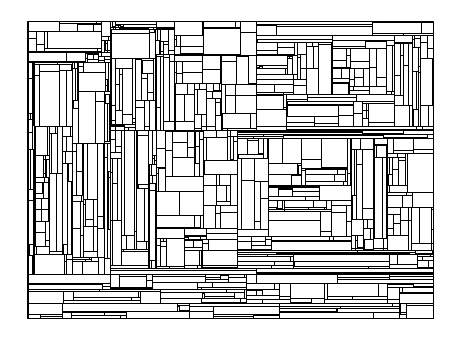

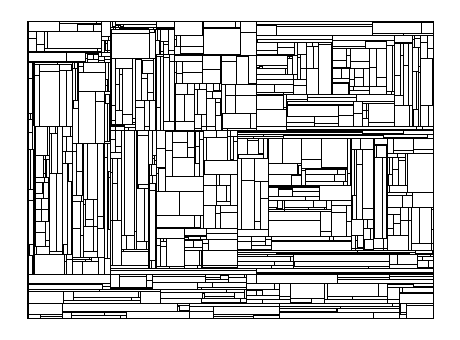

In [20]:
n_iter=400
np.random.seed(1)
plot_weighted_planar_stochastic_lattice(n_iter=n_iter)
np.random.seed(1)
WPSL().animate(n_iter=n_iter)

## Degree Distribution

Create a network s.t. every rectangle is a node, and pairs of nodes are connected if their rectangles are adjacent.
Count the degree of every node in the network.